# Finalized Initial Modeling

## Note {-}

This is an initial model that Kaitlyn and Lila have finalized. It's not great but, based on the research we've done into duplicate studies, has similar classification accuracy, ROC-AUC, and recall to existing models that have been optimized. 

The biggest thing that we need to focus on is **precision** which is currently lacking. 

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

In [2]:
# Loading datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Drop random column
train = train.drop(columns = 'Unnamed: 0')
test = test.drop(columns = 'Unnamed: 0')

### Undersampling

Note: the code below alters the train dataset so there is a **50-50 split** between readmitted values (zeros and ones).

In [3]:
# Filtering the dataset so that it only has not-readmitted vals
no_readmit = train[train['readmitted'] == 0]
readmit = train[train['readmitted'] == 1]

# Taking a random sample from the no_reamit df 
import random

n = 5041 # To get a 50-50 split, we need a sample of 5041
no_readmit1 = no_readmit.sample(n)

no_readmit.shape # (52173, 48)
readmit.shape # (5041, 48)
no_readmit1.shape # (5041, 48)

# Merging the no_readmit1 and readmit dfs to get a train1 df
merged_df = pd.concat([no_readmit1, readmit])
merged_df.shape

# Randomly shuffling the resulting df
train1 = merged_df.sample(frac=1)
train1.shape

(10023, 49)

### EDA with Relevant Variables

We've included some EDA and visualizations of the distributions of relevant variables that we included in the model below (all mapped against the response variable `readmitted`).

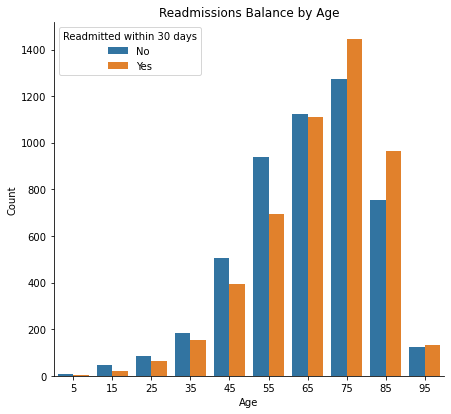

In [21]:
# Age

b = train1.age.unique()
b.sort()
b_sort = np.array(b).tolist()


ageplt = sns.countplot(x = 'age', hue = 'readmitted', data = train1, order = b_sort) 

sns.despine()
ageplt.figure.set_size_inches(7, 6.5)
ageplt.legend(title = 'Readmitted within 30 days', labels = ('No', 'Yes'))
ageplt.axes.set_title('Readmissions Balance by Age')
plt.ylabel('Count')
plt.xlabel('Age')
plt.show()

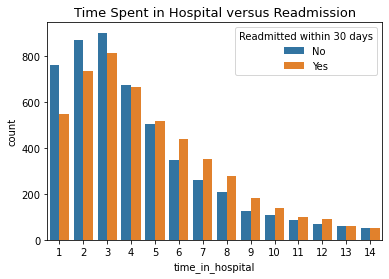

In [42]:
# Time in hospital 
c = train1.time_in_hospital.unique()
c.sort()
c_sort = np.array(c).tolist()

timeplt = sns.countplot(x = 'time_in_hospital', hue = "readmitted", data = train1, order = c_sort) 
plt.title('Time Spent in Hospital versus Readmission', size = 13)
timeplt.legend(title = 'Readmitted within 30 days', labels = ('No', 'Yes'))

plt.show()

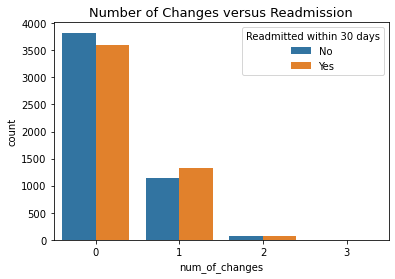

In [46]:
# Num of changes
d = train1.num_of_changes.unique()
d.sort()
d_sort = np.array(d).tolist()

changesplt = sns.countplot(x = 'num_of_changes', hue = "readmitted", data = train1, order = d_sort) 
plt.title('Number of Changes versus Readmission', size = 13)
changesplt.legend(title = 'Readmitted within 30 days', labels = ('No', 'Yes'))

plt.show()

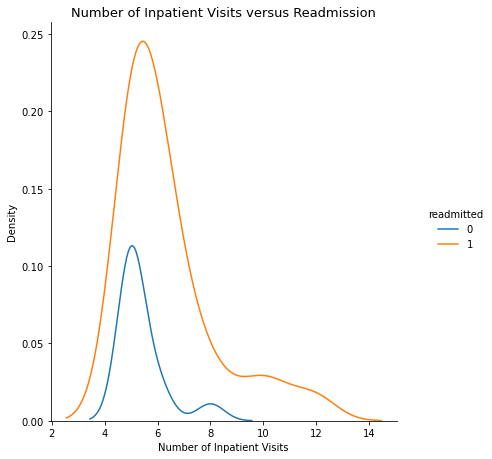

In [28]:
# Number inpatient
ax1 = sns.displot(train1.loc[train1['number_inpatient']>=5], x="number_inpatient", hue= 'readmitted', kind='kde')
plt.title('Number of Inpatient Visits versus Readmission', size = 13)
ax1.figure.set_size_inches(7, 6.5)
plt.xlabel('Number of Inpatient Visits')

plt.show()

### Possible Variable Interactions and Variables Plotted Against Each Other

<AxesSubplot:xlabel='age', ylabel='time_in_hospital'>

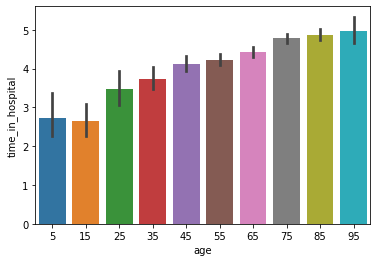

In [11]:
# Age vs time in hospital 
sns.barplot(x = "age", y = "time_in_hospital", data = train1)

<AxesSubplot:xlabel='time_in_hospital', ylabel='num_of_changes'>

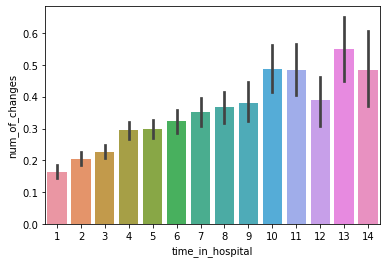

In [33]:
#num of changes vs time in hospital 
sns.barplot(x = "time_in_hospital", y = "num_of_changes", data = train1)

- Variability in num_of_changes increases with increasing number_inpatient
- Increasing variability at ages <35 with number_inpatient and num_of_changes
- No relationship between other variables -- time_in_hospital, num_of_changes, age, number_inpatient, discharge_disposition_id

### The Model

Below is the code for the model we created using the **train1** dataset. 

In [4]:
# Fitting a prelim model
logit_model = sm.logit(formula = 'readmitted ~ time_in_hospital*age + num_of_changes + number_inpatient', data = train1).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.674830
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10017
Method:                           MLE   Df Model:                            5
Date:                Mon, 20 Feb 2023   Pseudo R-squ.:                 0.02640
Time:                        15:09:31   Log-Likelihood:                -6763.8
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 4.142e-77
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.2233      0.161     -7.613      0.000      -1.538      -0.908
time_in_hospital         0.0926      0.033      2.845      0.004       0.029       0.156
age                      0.0126      0.002      5.299      0.000       0.008       0.017
time_in_hospital:age    -0.0007      0.000     -1.386      0.166      -0.002       0.000
num_of_changes           0.2105      0.044      4.773      0.000       0.124       0.297
number_inpatient         0.4296      0.034     12.664      0.000       0.363       0.496
========================================================================================
"""

In [5]:
# Alternative models 
alt_interaction_model = sm.logit('readmitted ~ num_of_changes*time_in_hospital + number_inpatient + age', train1).fit()
both_interaction_model = sm.logit('readmitted ~ num_of_changes*time_in_hospital + age*time_in_hospital + number_inpatient', train1).fit()

Optimization terminated successfully.
         Current function value: 0.674156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674028
         Iterations 5


### Confusion Matrix

<br> Below is the confusion matrix for the model above. The main metrics to note are as follows: 

1. Classification accuracy = 63.9%
2. Precision = 12.3%
3. TPR or Recall = 48.0%
4. FNR = 52.0%
5. FPR = 34.5%
6. ROC-AUC = 60.1%

<br> Confusion matrix for a different model (unsure which one... )

1. Classification accuracy = 64.1%
2. Precision = 12.2%
3. TPR or Recall = 47.3%
4. FNR = 52.7%
5. FPR = 34.2%
6. ROC-AUC = 59.9%

In [6]:
from sklearn.metrics import roc_curve, auc

#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

Classification accuracy = 63.9%
Precision = 12.3%
TPR or Recall = 48.0%
FNR = 52.0%
FPR = 34.5%
ROC-AUC = 60.1%


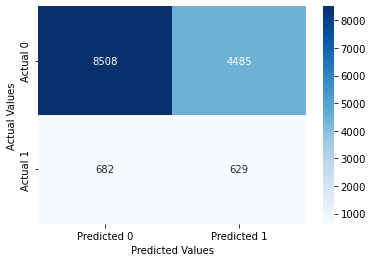

In [7]:
# Printing the confusion matrix of the model
confusion_matrix_data(test,test.readmitted,logit_model)

### Cross-Validation

Based on the findings above, we think the following will be the most helpful regarding cross-validation: 

1. Changing the distribution of 'readmitted' in the train dataset (perhaps trying out a 60-40 or a 70-30 split instead of 50-50)? 
2. Whatever else feels good!